(2253, 2000, 3)


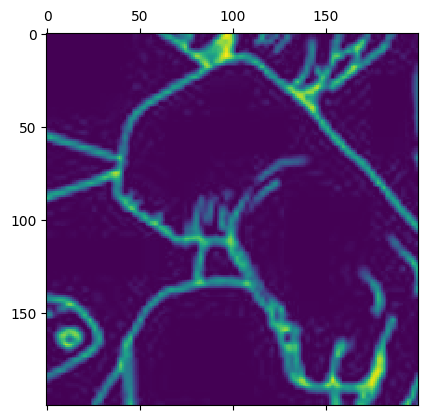

In [60]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
import random 

# Load image"
# image_path = "/Users/nshelton/Pictures/gundam_title.png"
# image_path = "/Users/nshelton/Pictures/akira.jpeg"
image_path = "/Users/nshelton/Pictures/akira.jpeg"
# image_path = "/Users/nshelton/Pictures/stairs.png"

image = cv2.imread(image_path)
print(image.shape)

# image[:,:,1] = image[:,:,0]
# image[:,:,2] = image[:,:,0]

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image_gray = cv2.resize(image_gray, (-1,-1), fx = 2, fy = 2)
 
# _ , filtered =  cv2.threshold(image_gray, 150, 255, cv2.THRESH_BINARY_INV)


filtered = image_gray

# sigma = 2
# min_canny = 2
# max_canny = 100
# filtered = canny(image_gray, sigma, min_canny, max_canny).astype(np.uint8) * 255


filtered = 255 - filtered

# filtered = filtered[50:150, 50:150]
filtered = filtered[1000:1200, 1000:1200]
cv2.imwrite("filtered.png", filtered)



plt.matshow(filtered)


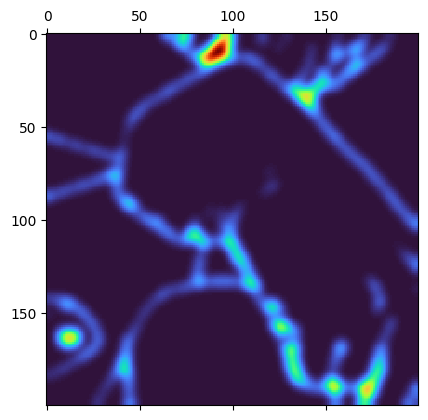

In [67]:
erode_stack = filtered.copy()

_, erode_stack = cv2.threshold(erode_stack, 64, 255,  cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

distance_field = []
for i in range(10) : 
    erode_stack = cv2.erode(erode_stack, kernel)
    distance_field.append(erode_stack)

distance_field = (np.array(distance_field) > 0).sum(axis=0).astype(np.float32)
for i in range(10):
    distance_field = cv2.blur(distance_field, (3,3))

# distance_field = distance_field.max() - distance_field
plt.matshow(distance_field, cmap="turbo")


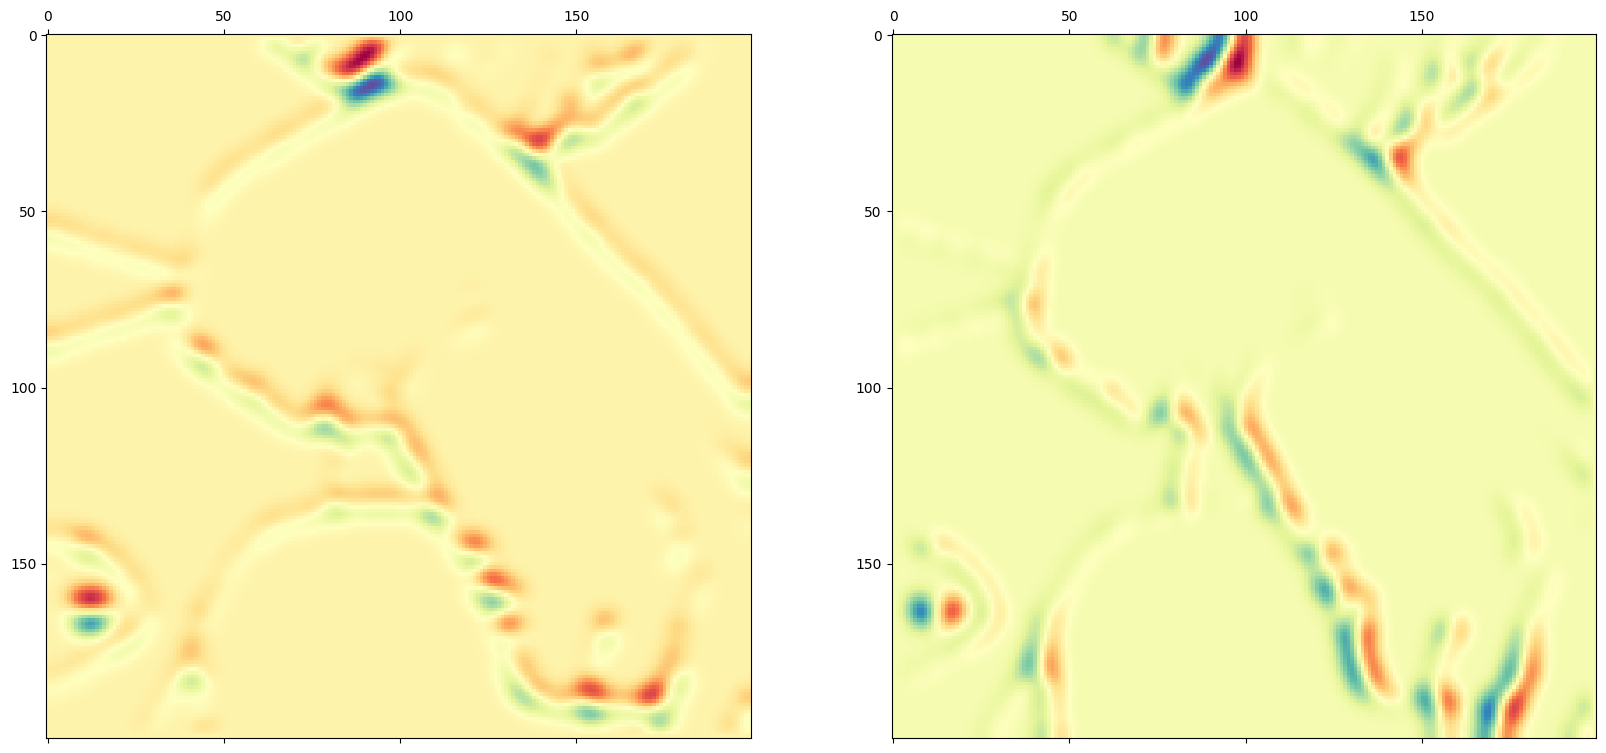

In [68]:
def placePoints(image):
    points = []
    values = []

    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            pixel = np.array((col, image.shape[0] - row))
            value = image[row, col]
            if ( value > 20) :
                values.append(value)
                points.append(pixel)


    points = np.array(points)
    values = np.array(values)
    # subset_idx = np.random.choice(points.shape[0], 10000, replace=False)  
    # points_subset = points[subset_idx]

    plt.figure(figsize=(image.shape[1]/30,image.shape[0]/30))
    plt.scatter(points[:,0], points[:,1], s = 0.1 )


scale = 1
delta = 0
kernel_size=1


ddepth = cv2.CV_32F

blurred = distance_field.copy().astype(np.float32)

# for i in range(10):
    # blurred = cv2.blur(blurred, ksize=(5,5))


grad_x = cv2.Sobel(blurred, ddepth, 1, 0, ksize=kernel_size, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(blurred, ddepth, 0, 1, ksize=kernel_size, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Orthogonal field
flow_field = np.dstack([-grad_y, grad_x]) / ( (2 * kernel_size + 1) * (2 * kernel_size + 1))
# flow_field = np.dstack([grad_x, grad_y]) / ( (2 * kernel_size + 1) * (2 * kernel_size + 1))

ax1.matshow(flow_field[:,:,0], cmap="Spectral")
ax2.matshow(flow_field[:,:,1],  cmap="Spectral")
# plt.show()
# plt.plot(flow_field[100,:,0])
# plt.plot(flow_field[100,:,1])

/var/folders/4n/l5_t325s5t59l1gqv4jd3h7c0000gn/T/ipykernel_72468/611180108.py:10: RuntimeWarning: invalid value encountered in divide
  U = flow_field[:,:,0] / flow_field_mag
/var/folders/4n/l5_t325s5t59l1gqv4jd3h7c0000gn/T/ipykernel_72468/611180108.py:11: RuntimeWarning: invalid value encountered in divide
  V = flow_field[:,:,1] / flow_field_mag


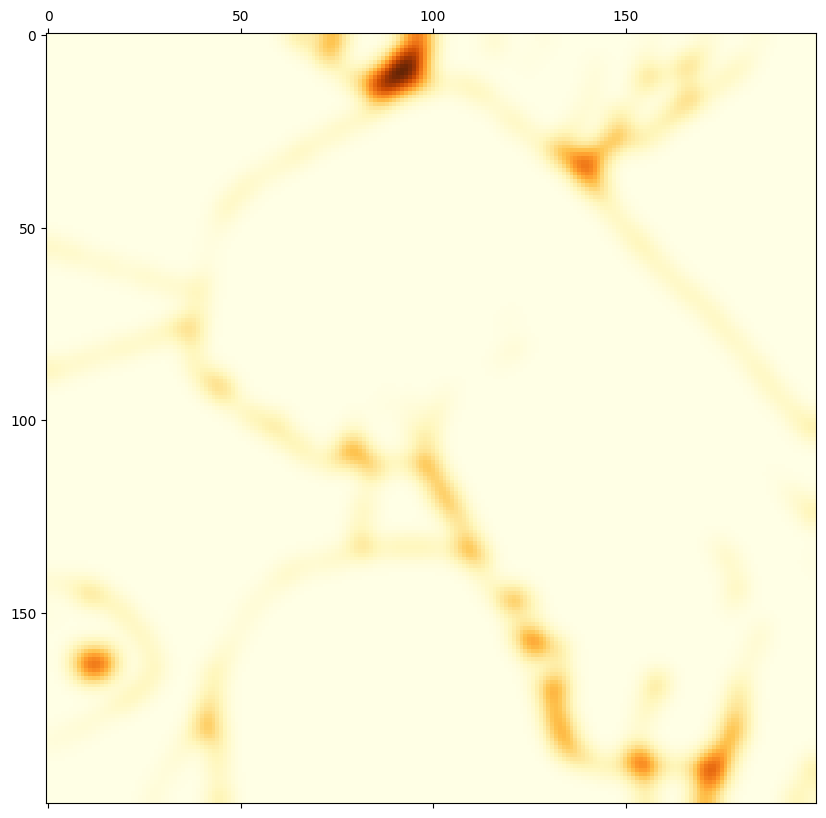

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# plt.style.use('_mpl-gallery-nogrid')

# make data
X, Y = np.meshgrid(range(flow_field.shape[1]), range(flow_field.shape[0]))

flow_field_mag = np.linalg.norm(flow_field, axis=2)
U = flow_field[:,:,0] / flow_field_mag
V = flow_field[:,:,1] / flow_field_mag

# plot
fig, ax = plt.subplots(figsize=(10,10))

# ax.quiver(X, Y, U, V, color="blue", angles='xy', scale_units='xy', scale=1, width=.0015, alpha = 0.5)

ax.matshow(distance_field, cmap="YlOrBr")
plt.show()



In [83]:
distance_field /= distance_field.max()

In [84]:
distance_field

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.10496181, 0.09578313,
        0.09195773],
       [0.        , 0.        , 0.        , ..., 0.10186294, 0.08990704,
        0.08506332],
       [0.        , 0.        , 0.        , ..., 0.10070836, 0.08779684,
        0.08260515]], dtype=float32)

In [90]:
from pathUtils import *
from tqdm import tqdm

remaining_ink = distance_field.copy().astype(np.float32)
# remaining_ink = cv2.blur(remaining_ink, (7,7))
all_strokes_raster = np.ones(remaining_ink.shape) * 255
all_paths = []

while len(all_paths) < 5000 and remaining_ink.sum() > 1:
    def lookupxy(raster, xy):
        if int(xy[1]) > 0 and int(xy[1]) < raster.shape[0] and  int(xy[0]) > 0 and int(xy[0]) < raster.shape[1]:
            return raster[int(xy[1]), int(xy[0])]
        return np.nan

    def placeStroke(input_raster, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start)

        window = 4
        max_val = lookupxy(input_raster, pos)
        while max_val > 0:
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(
                img[
                    pos[1] - window : pos[1] + window + 1,
                    pos[0] - window : pos[0] + window + 1,
                ]
            )
            pos += np.array(max_loc) - window
            path.append(pos.copy())
            cv2.circle(img, pos, window - 1, 0, -1)

        return path

    def placeStrokeOrthogonalGradient(input_raster, flow_field, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start, np.float32)
        print("start at", pos, lookupxy(img, pos))

        speed = 2
        while (
            int(pos[0]) < img.shape[1] and int(pos[1]) < img.shape[0]
            and lookupxy(img, pos) > 0
        ):
            path.append(pos.copy())
            cv2.circle(img, (round(pos[1]), round(pos[0])), speed , 0, -1)

            flow = lookupxy(flow_field, pos)
            magnitude = np.linalg.norm(flow)
            print("flow", flow, magnitude, pos)
            if magnitude < 0.001:
                break

            delta = speed * flow / magnitude
            print("delta", delta)
            pos += delta
            print("newpos ",pos, img.shape, lookupxy(img, pos))

        return path

    line_thickness = 4

    def rasterStroke(dims, path):
        img = np.zeros(dims)

        if (len(path)) == 1:
            cv2.circle(
                img, (round(path[0][0]), round(path[0][1])), line_thickness, 255, -1
            )

        for i in range(len(path) - 1):
            a = (round(path[i][0]), round(path[i][1]))
            b = (round(path[i + 1][0]), round(path[i + 1][1]))
            cv2.line(img, a, b, 255, line_thickness, cv2.LINE_AA)

        return img

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(remaining_ink)
    print(remaining_ink.sum(), "\t", len(all_paths), end="\t\t\t\r")
    
    new_stroke = placeStroke(remaining_ink, max_loc)

    np_stroke = np.array(new_stroke)

    all_paths.append(new_stroke)
    stroke_raster = rasterStroke(remaining_ink.shape, new_stroke)

    remaining_ink = np.clip(remaining_ink - stroke_raster, 0,255)
    # remaining_ink = cv2.blur(remaining_ink, (1,1))
    all_strokes_raster = np.clip(
        all_strokes_raster.astype(np.int32) - stroke_raster.astype(np.int32) * 255,
        0,
        255,
    ).astype(np.uint8)
    
    cv2.imwrite("current_stroke.png", (all_strokes_raster).astype(np.uint8))
    cv2.imwrite("remaining_ink.png", remaining_ink)


5000


In [95]:


path_list = [[p for p in path] for path in all_paths if len(path) > 0.1]

print(len(all_paths))
print(len(path_list))

merge_threshold = 5

for i in tqdm(range(len(path_list))):
    len_before = len(path_list)
    path_list = merge_one_path_kd(path_list, merge_threshold)
    if len_before == len(path_list):
        break

def getPathLength(path):
    length = 0
    for i in range(len(path) - 1):
        length += np.linalg.norm(path[i] - path[i+1])
    return length

path_list = close_loops(path_list)
path_list  = [np.array(path) for path in path_list]

path_list = [path for path in path_list if getPathLength(path) > 2]
path_list = smooth_all_2(path_list, 0.01)
path_list = simplify_all(path_list, 0.001)
path_list = smooth_all_2(path_list, 0.1)
path_list = simplify_all(path_list, 0.1)

RENDER_SCALE = 0.5
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

5000
13


 38%|███▊      | 5/13 [00:00<00:00, 944.66it/s]


True

In [ ]:
from tqdm import tqdm
import numpy as np
from scipy.spatial import KDTree

points = []
for row in range(0, filtered.shape[0], 5):
    for col in range(0, filtered.shape[1], 5):
        points.append([col, row])


def lookupxy(raster, xy):
    if int(xy[1]) > 0 and int(xy[1]) < raster.shape[0] and  int(xy[0]) > 0 and int(xy[0]) < raster.shape[1]:
        return raster[int(xy[1]), int(xy[0])]
    return np.nan

print(len(points), "seeds")
all_paths = []

for p in points:
    path = []
    pos = np.array(p, np.float32)
    for i in range(100):
        if lookupxy(filtered, pos) < 10 :
            break

        path.append(pos.copy())
        flow = lookupxy(flow_field, pos) * 0.1
        if np.any(np.isnan(flow)) :
            break

        pos += flow

    all_paths.append(path)

 
path_list = [[p for p in path] for path in all_paths if len(path) > 1]

print(path_list, len(path_list))

merge_threshold = 5

for i in tqdm(range(len(path_list))):
    len_before = len(path_list)
    path_list = merge_one_path_kd(path_list, merge_threshold)
    if len_before == len(path_list):
        break

def getPathLength(path):
    length = 0
    for i in range(len(path) - 1):
        length += np.linalg.norm(path[i] - path[i+1])
    return length

path_list = close_loops(path_list)
path_list  = [np.array(path) for path in path_list]

path_list = [path for path in path_list if getPathLength(path) > 2]
path_list = smooth_all_2(path_list, 0.01)
path_list = simplify_all(path_list, 0.001)
path_list = smooth_all_2(path_list, 0.1)
path_list = simplify_all(path_list, 0.1)

RENDER_SCALE = 0.5
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)



1600 seeds
[[array([65.,  5.], dtype=float32), array([65.31111,  5.     ], dtype=float32), array([65.62222,  5.     ], dtype=float32), array([65.933334,  5.      ], dtype=float32), array([66.244446,  5.      ], dtype=float32), array([66.87778 ,  5.311111], dtype=float32), array([67.51111 ,  5.622222], dtype=float32), array([69.08888 ,  6.255555], dtype=float32), array([70.66666 ,  7.511111], dtype=float32), array([71.92221 ,  8.766666], dtype=float32), array([73.177765, 10.022222], dtype=float32), array([74.43332 , 10.655555], dtype=float32), array([76.633316, 11.922221], dtype=float32), array([78.84443 , 14.133332], dtype=float32), array([80.09998 , 14.766665], dtype=float32), array([83.56665 , 17.277777], dtype=float32), array([85.133316, 20.744444], dtype=float32), array([87.96665, 17.91111], dtype=float32), array([93.633316, 16.655554], dtype=float32), array([97.722206, 15.399999], dtype=float32), array([101.18887  ,  14.1444435], dtype=float32), array([104.02221 ,  12.888888], dty

 46%|████▌     | 196/428 [00:00<00:00, 297.13it/s]


True

In [ ]:
import json
import uuid

projects_folder = "/Users/nshelton/Hephaestus/projects"

def writePlot(paths):
    dictionary = {
        "created_time": "4/7/2024 4:42:27 PM",
        "modified_time": "4/7/2024 6:27:36 PM",
        "camera_position": [100, 100],
        "zoom": 10.702,
        "aspect": 0.563,
        "dom_element": {},
        "plot_models": [],
    }

    dictionary["plot_models"].append(
        {
            "position": {"x": 0, "y": 0},
            "paths": [path.tolist() for path in path_list],
            "scale": 0.1,
            "id": str(uuid.uuid4()),
            "state": "none",
        }
    )


    with open(projects_folder + "/akiraflow.json", "w") as outfile:
        json.dump(dictionary, outfile)

writePlot(path_list)


In [ ]:
# def lookupxy(raster, xy):
#     if int(xy[1]) > 0 and int(xy[1]) < raster.shape[0] and  int(xy[0]) > 0 and int(xy[0]) < raster.shape[1]:
#         return raster[int(xy[1]), int(xy[0])]
#     return np.nan

# from pathUtils import * 

# from scipy.spatial import KDTree

# points.shape

# paths = []
# visited = np.zeros(values.shape)

# start_idx = int(random.random()* 1000)
# print(start_idx, values[start_idx], points[start_idx])

# path = []
# current_idx = start_idx

# for i in range(1000):
#     tree = KDTree(points[visited == 0])
#     pos = points[current_idx]
#     path.append(pos)
#     visited[current_idx] = 1

#     flow = lookupxy(flow_field, pos)
#     magnitude = np.linalg.norm(flow)
#     print(pos, flow)
#     if (np.isnan(magnitude)):
#         break

#     query_point = pos + flow
#     distance, idx = tree.query(query_point, k=2)

#     if (distance[1] > 10) : 
#         break

#     current_idx = idx[1]

# print(len (path))
# paths.append(path)

# path_render = plotPaths(paths, 1)
# cv2.imwrite("render.png", path_render )

684 22 [109 159]
[109 159] [-0.00373333 -0.07466667]
[109 158] [ 0.02897778 -0.07573333]
[108 157] [ 0.03306667 -0.11911113]
[106 156] [-0.04533333 -0.12462221]
[103 155] [-0.03857777 -0.06506666]
[ 91 154] [-2.380978  -3.2458665]
[ 82 151] [2.0591998 2.922311 ]
[ 78 153] [0.42986667 0.6026666 ]
[ 45 153] [0.63786656 2.6504889 ]
[ 41 155] [0.02097776 0.05262221]
[ 38 156] [-0.17511113 -0.10471114]
[246 157] [-2.526755 -5.156089]
[226 155] [0.00515556 0.07964444]
[181 156] [2.2595553 4.0126224]
[180 157] [2.0362668 3.1923556]
[179 159] [1.0032     0.46595553]
[123 159] [ 0.00515555 -0.01848888]
[120 158] [ 0.02115554 -0.06542224]
[107 157] [ 0.01706669 -0.15413335]
[ 88 156] [1.2531561 1.0211555]
[ 85 157] [2.3989334 2.8195558]
[ 88 160] [2.6705778 2.5507557]
[ 91 162] [2.6467557 2.8097775]
[ 93 165] [2.704711 2.308089]
[ 95 167] [2.6634667 2.3368888]
[ 95 168] [1.967289  1.7815111]
[ 95 167] [2.6634667 2.3368888]
[ 95 166] [3.0785778 2.7091556]
[ 95 166] [3.0785778 2.7091556]
[ 94 166]

True

In [ ]:
import cv2
import numpy as np

from pathUtils import *

remaining_ink = filtered.copy()
all_strokes_raster = np.ones(remaining_ink.shape) * 255

all_paths = []

while len(all_paths) < 500 and remaining_ink.sum() > 10:

    def lookupxy(raster, xy):
        if int(xy[1]) > 0 and int(xy[1]) < raster.shape[0] and  int(xy[0]) > 0 and int(xy[0]) < raster.shape[1]:
            return raster[int(xy[1]), int(xy[0])]
        return np.nan


    def placeStroke(input_raster, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start)

        window = 2

        max_val = lookupxy(input_raster, pos)

        while max_val > 0:
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(
                img[
                    pos[1] - window : pos[1] + window + 1,
                    pos[0] - window : pos[0] + window + 1,
                ]
            )
            pos += np.array(max_loc) - window
            path.append(pos.copy())
            cv2.circle(img, pos, window - 1, 0, -1)

        return path

    def placeStrokeOrthogonalGradient(input_raster, flow_field, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start, np.float32)
        print("start at", pos, lookupxy(img, pos))

        speed = 2
        while (
            int(pos[0]) < img.shape[1] and int(pos[1]) < img.shape[0]
            and lookupxy(img, pos) > 0
        ):
            path.append(pos.copy())
            cv2.circle(img, (round(pos[1]), round(pos[0])), speed , 0, -1)

            flow = lookupxy(flow_field, pos)
            magnitude = np.linalg.norm(flow)
            print("flow", flow, magnitude, pos)
            if magnitude < 0.001:
                break

            delta = speed * flow / magnitude
            print("delta", delta)
            pos += delta
            print("newpos ",pos, img.shape, lookupxy(img, pos))

        return path

    line_thickness = 2

    def rasterStroke(dims, path):
        print(len(path))

        img = np.zeros(dims)

        if (len(path)) == 1:
            cv2.circle(
                img, (round(path[0][0]), round(path[0][1])), line_thickness, 255, -1
            )

        for i in range(len(path) - 1):
            a = (round(path[i][0]), round(path[i][1]))
            b = (round(path[i + 1][0]), round(path[i + 1][1]))
            cv2.line(img, a, b, 255, line_thickness, cv2.LINE_AA)

        return img

    print(remaining_ink.sum(), "\t", len(all_paths), end="\t\t\t\r")
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(remaining_ink)

    # new_stroke = placeStroke(remaining_ink, max_loc)
    new_stroke = placeStrokeOrthogonalGradient(remaining_ink, flow_field, max_loc)



    print("new_stroke", new_stroke)
    all_paths.append(new_stroke)
    stroke_raster = rasterStroke(remaining_ink.shape, new_stroke)
    remaining_ink = np.clip(remaining_ink - stroke_raster, 0, 255)
    all_strokes_raster = np.clip(
        all_strokes_raster.astype(np.int32) - stroke_raster.astype(np.int32) * 255,
        0,
        255,
    ).astype(np.uint8)

    cv2.imwrite("current_stroke.png", (all_strokes_raster).astype(np.uint8))
    cv2.imwrite("remaining_ink.png", remaining_ink)

# cv2.imwrite("current_stroke.png",  (all_strokes_raster).astype(np.uint8))
path_list = [[p.tolist() for p in path] for path in all_paths if len(path) > 1]

print(len(path_list))

RENDER_SCALE = 0.5
# connect_close_paths(path_list)
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

In [ ]:
from tqdm import tqdm


import numpy as np
from scipy.spatial import KDTree
 
path_list = [[p.tolist() for p in path] for path in all_paths if len(path) > 1]

print(len(path_list))

merge_threshold = 5

for i in tqdm(range(len(path_list))):
    len_before = len(path_list)
    path_list = merge_one_path_kd(path_list, merge_threshold)
    if len_before == len(path_list):
        break

print("merged to", len(path_list))


path_list = close_loops(path_list)

print("closed loops", len(path_list))

path_list  = [np.array(path) for path in path_list]

for _ in range(1):
    path_list = smooth_all_2(path_list, 0.01)

print("smoothed 1", len(path_list))

path_list = simplify_all(path_list, 0.001)

print("simplify_all 1", len(path_list))

for _ in range(1):
    path_list = smooth_all_2(path_list, 0.1)

print("smoothed 2", len(path_list))

path_list = simplify_all(path_list, 0.1)
print("simplify 2", len(path_list))

RENDER_SCALE = 0.5
# connect_close_paths(path_list)
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)


import json 
import uuid

projects_folder = "/Users/nshelton/Hephaestus/projects"

def writePlot(paths):
    dictionary = {
        "created_time": "4/7/2024 4:42:27 PM",
        "modified_time": "4/7/2024 6:27:36 PM",
        "camera_position": [100, 100],
        "zoom": 10.702,
        "aspect": 0.563,
        "dom_element": {},
        "plot_models": [],
    }

    dictionary["plot_models"].append(
        {
            "position": {"x": 0, "y": 0},
            "paths": [path.tolist() for path in path_list],
            "scale": 0.03,
            "id": str(uuid.uuid4()),
            "state": "none",
        }
    )


    with open(projects_folder + "/akiraflow.json", "w") as outfile:
        
        json.dump(dictionary, outfile)


writePlot(path_list)